In [20]:
import os, shutil, requests
import osmnx as ox
import networkx as nx
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import matplotlib.pyplot as plt
from pyproj import CRS

## Read in the data

In [2]:
#Filenames
DCFC_filename = 'Data\\NC_DCFC.shp'
graph_filename = 'Data\\NC_highways_all.graphml'

In [3]:
#Read DCFC points into geodataframe
print(f"Loading DCFC points from {DCFC_filename}")
gdf_DCFC = gpd.read_file(DCFC_filename)

Loading DCFC points from Data\NC_DCFC.shp


In [4]:
print(f"Loading graph from {graph_filename}")
nc_graph = ox.load_graphml(filename=os.path.basename(graph_filename),
                           folder=os.path.dirname(graph_filename))

Loading graph from Data\NC_highways_all.graphml


In [6]:
#Convert graph to a geodataframes
gdf_nodes, gdf_edges = ox.graph_to_gdfs(nc_graph)

In [7]:
#Project to UTM (for analysis)
utm17N_prj = CRS.from_epsg(32617)
gdf_edges_utm = gdf_edges.to_crs(utm17N_prj)
gdf_DCFC_utm = gdf_DCFC.to_crs(utm17N_prj)

#Project to Web Mercator (for plotting)
wm_prj = CRS.from_epsg(3857)
gdf_edges_wm = gdf_edges.to_crs(wm_prj)
gdf_DCFC_wm = gdf_DCFC.to_crs(wm_prj)

## Visualize the data

In [ ]:
#Plot the data
ax = gdf_edges_wm.plot(figsize=(20,10))
gdf_DCFC_wm.plot(color='red',ax=ax)
ctx.add_basemap(ax)

## Identify "Anxious Areas"
Identify all "safe" areas, i.e., all alreas within a 50 mile drive of a DCFC charging location.

Source: https://github.com/gboeing/osmnx-examples/blob/master/notebooks/13-isolines-isochrones.ipynb

In [21]:
polys = []
subgraphs = []
for i, row in gdf_DCFC.iterrows():
    #Status
    print('.',end='')
    #Get the coordinates
    thePoint = (row.geometry.y, row.geometry.x)
    #Get the ID
    theID = row.id
    #Get the nearest node
    theNode = ox.get_nearest_node(nc_graph,thePoint)
    #Get the subgraph
    subgraph = nx.ego_graph(nc_graph,theNode,radius=25*1609.34,distance='length')
    #Get the nodes in the subgraph
    node_points = [Point((data['x'],data['y'])) for node, data in subgraph.nodes(data=True)]
    #Get the bounding poly
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    #Add the polygon
    if bounding_poly.area > 0:
        polys.append(bounding_poly)
        subgraphs.append(subgraph)
    #Export the subgraph
    # ox.save_graph_shapefile(subgraph,filename=f"sub{theID}",folder='Data/Subgraphs')

....................................................................

In [27]:
polys = []
subgraphs = []
from shapely.geometry import LineString
for i, row in gdf_DCFC.iterrows():
    #Status
    print('.',end='')
    #Get the coordinates
    thePoint = (row.geometry.y, row.geometry.x)
    #Get the ID
    theID = row.id
    #Get the nearest node
    theNode = ox.get_nearest_node(nc_graph,thePoint)
    #Get the subgraph
    subgraph = nx.ego_graph(nc_graph,theNode,radius=25*1609.34,distance='length')
    #Get the nodes in the subgraph
    node_points = [Point((data['x'],data['y'])) for node, data in subgraph.nodes(data=True)]
    
    # Buffer
    nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
    nodes_gdf = nodes_gdf.set_index('id')

    edge_lines = []
    for n_fr, n_to in subgraph.edges():
        f = nodes_gdf.loc[n_fr].geometry
        t = nodes_gdf.loc[n_to].geometry
        edge_lines.append(LineString([f,t]))

    n = nodes_gdf.buffer(50).geometry
    e = gpd.GeoSeries(edge_lines).buffer(50).geometry
    all_gs = list(n) + list(e)
    new_iso = gpd.GeoSeries(all_gs).unary_union

    # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
    #if infill:
    #    new_iso = Polygon(newa_iso.exterior)
    
    #Get the bounding poly
    #bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    #Add the polygon
    polys.append(new_iso)
    subgraphs.append(subgraph)
    #Export the subgraph
    # ox.save_graph_shapefile(subgraph,filename=f"sub{theID}",folder='Data/Subgraphs')

.....

KeyboardInterrupt: 

In [22]:
from descartes import PolygonPatch
import matplotlib.pyplot as plt

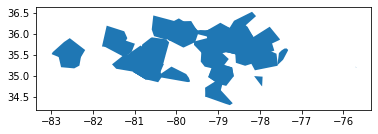

In [23]:
gpd.GeoSeries(polys).plot()

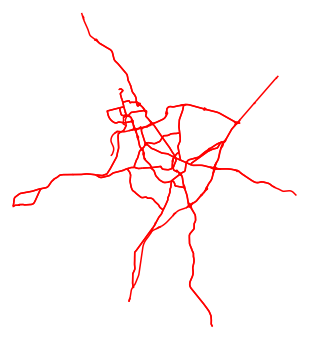

In [24]:
fig, ax = ox.plot_graph(nc_graph, fig_height=10,
                        show=False, edge_color='k', edge_alpha=0.2, node_color='none',close=True)
theLine = ox.plot_graph(subgraphs[1],edge_linewidth=1.5,node_color='none',edge_color='r')

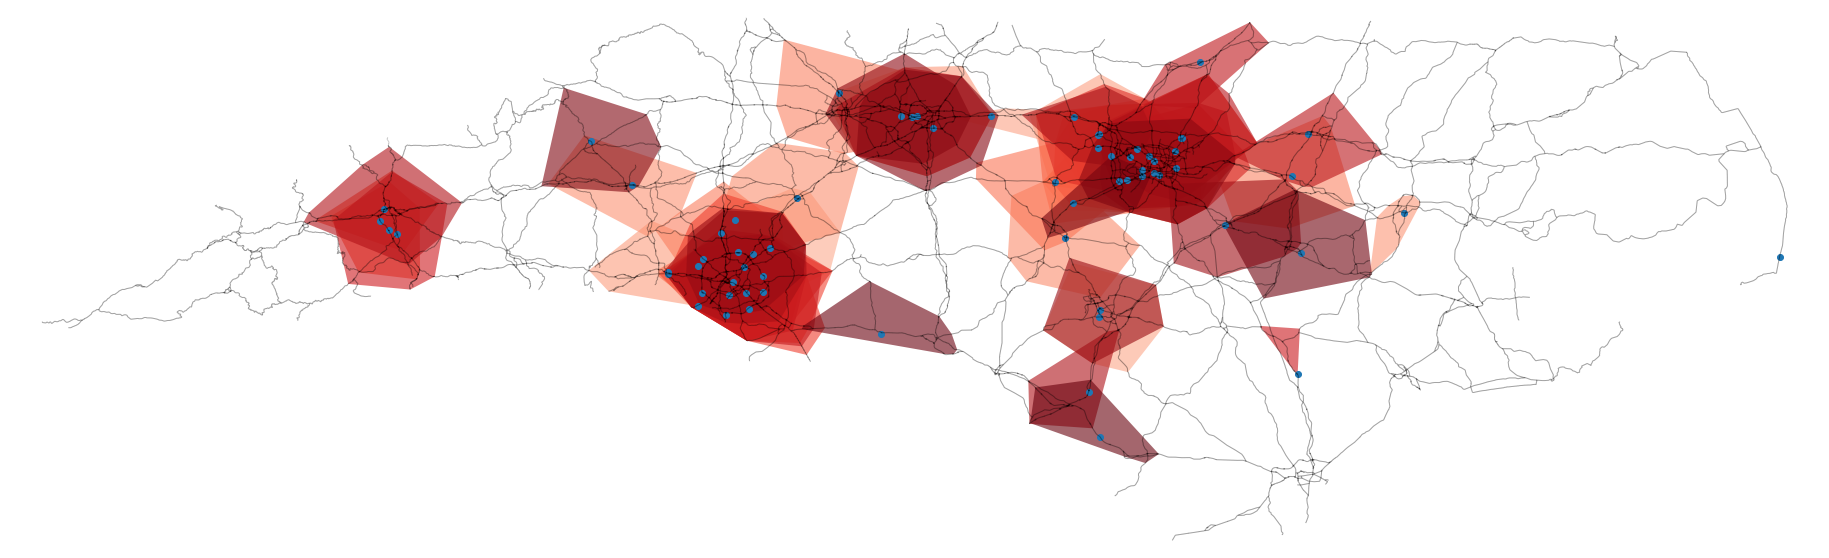

In [25]:
iso_colors = ox.get_colors(n=len(polys), cmap='Reds', start=0.3, return_hex=True)
fig, ax = ox.plot_graph(nc_graph, fig_height=10,show=False, close=False, edge_color='k', edge_alpha=0.2, node_color='none')
for polygon, fc in zip(polys, iso_colors):
    if polygon.area > 0:
        patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch)
gdf_DCFC.plot(ax=ax)
plt.show()

## Next step:
The above figure reveals how far a car with 50 mile capacity 